In [1]:
#Bibliotecas
import numpy as np
import tensorflow as tf
import math 
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.append(ROOT_DIR)

from utils import *
from loss import *
from resUnet import *
from dcUnet import *
from config import *
from dataReader import *

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


2022-08-18 00:06:21.387707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 00:06:21.387735: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def reshapeImg(patches, shape, size_patche):
    qtd_linha = math.ceil(shape[0]/config.ksize)
    qtd_coluna = math.ceil(shape[1]/config.ksize)
    linha = qtd_linha*config.ksize
    coluna = qtd_coluna*config.ksize

    img = np.empty([linha, coluna], dtype=float)
    cont = 0
    for l in range(qtd_linha):
        for c in range(qtd_coluna):
            lin = l*size_patche
            col = c*size_patche
            img[lin:(lin+size_patche),col:(col+size_patche)] = patches[cont][:,:,0]
            cont += 1

    img = tf.expand_dims(img, -1)
    return img

### Carrega a base

In [3]:
def load_dataset_test(config, split):
    #splits = ['test1', 'test2']
    #for sdx, split in enumerate(splits):                
    base_teste = None
    if config.patche:
        base_teste = DataGenPatche(config, split, config.dataset_path, batch_size=1, image_size=config.image_width)
    else:
        base_teste = DataGen(config, split, config.dataset_path, batch_size=1, image_size=config.image_width)
    
    return base_teste

# Carrega a configuração do modelo
def load_config(log_path):
    folder_modeling_path = "/data/mayaragomes/dissertacao/proposta/segmentation/" + log_path
    config_dict = read_config_dict(folder_modeling_path)
    
    config = Config()
    config.folder_modeling_path = config_dict["folder_modeling_path"]
    config.image_width = int(config_dict["image_width"])
    config.image_height = int(config_dict["image_height"])
    config.num_channels = int(config_dict["num_channels"])
    config.name_model = config_dict["name_model"]
    config.dataset_path = "/data/mayaragomes/dissertacao/"
    config.name_modelagem = config_dict["name_modelagem"]
    config.name_loss = config_dict["name_loss"]    
    config.ksize = int(config_dict["ksize"])
    config.strides = int(config_dict["strides"])
    config.input_size = (config.image_height, config.image_width, config.num_channels)

    if config_dict["augmentation"] == 'None':
        config.augmentation = None
    else:
        config.augmentation = True
    if config_dict["patche"] == 'False':
        config.patche = False
    else:
        config.patche = True

    return config
       

In [4]:
# Carrega as configurações para cada modelo
logs_paths = ["dcunet/1_dcunet_focal_tversky_aumentation/",
                    "dcunet/1_dcunet_generalized_dice_loss_aumentation/",
                    "resUnet/1_resUnet_focal_tversky_aumentation/",
                    "resUnet/1_resUnet_generalized_dice_loss_aumentation/"]

config_models = []
for log_path in logs_paths:
    config_model = load_config(log_path)
    config_models.append(config_model)
    

In [5]:
print(config_models[0].__dict__)

{'prefixo': '1_', 'image_width': 256, 'image_height': 256, 'input_size': (256, 256, 1), 'batch_size': 8, 'num_classes': 1, 'num_channels': 1, 'num_epochs': 300, 'resize': False, 'augmentation': True, 'neighborhood': 8, 'split': False, 'EarlyStopping': True, 'name_model': 'dcunet', 'dataset_path': '/data/mayaragomes/dissertacao/', 'folder_modeling_path': '/data/mayaragomes/dissertacao/proposta/segmentation/dcunet/1_dcunet_focal_tversky_aumentation', 'name_modelagem': '1_dcunet_focal_tversky_aumentation', 'name_loss': 'focal_tversky', 'inline': True, 'crossline': True, 'ksize': 256, 'strides': 256, 'padding': 'SAME', 'patche': False, 'baselist': None, 'warmup_epoch': 15, 'learning_rate': 0.001, 'learning_rate_callback': ''}


In [6]:
splits = ['test1', 'test2']
base_teste1 = load_dataset_test(config_models[0], splits[0])
base_teste2 = load_dataset_test(config_models[0], splits[1])

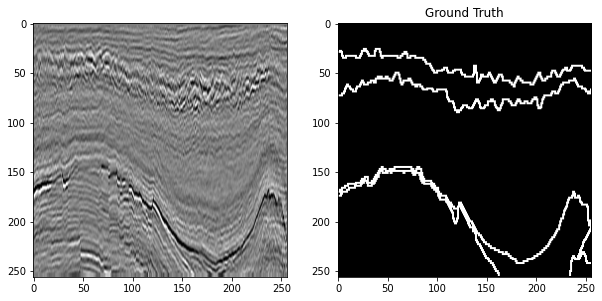

In [7]:
images, masks, directions, numbers, indexs, shape = base_teste1[0]

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(images[0][:,:,0], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(masks[0][:,:,0], 'gray')
plt.title('Ground Truth') 
plt.show()


In [8]:
print(splits[0], config_models[0].dataset_path, config_models[0].image_width)
#X_base, Y_base, d, n = base_teste1.loadDataSet()
#print("Evaluate on test data", np.array(X_base).shape, np.array(Y_base).shape)

test1 /data/mayaragomes/dissertacao/ 256


### Carrega os modelos

In [9]:
def load_model(config, idx):
    model = config.getModel()
    function_loss = config.getLoss()
    model.load_weights(config.folder_modeling_path + "/Train/" + str(idx) + "/logs/Unet.h5")

    model.compile(
        optimizer="adam",
        loss=function_loss,
        metrics=[
            qtd_TP,
            dice_coef,         
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5),  # jaccard binario
        ],
    )

    return model

In [10]:
# Carrega os modelos
models = []
for c in config_models:
    m = load_model(c, 0)
    models.append(m)

modelo DC-Unet


2022-08-18 00:06:39.488243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/mayaragomes/envs/tensorflow/lib/python3.7/site-packages/cv2/../../lib64:
2022-08-18 00:06:39.488351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/mayaragomes/envs/tensorflow/lib/python3.7/site-packages/cv2/../../lib64:
2022-08-18 00:06:39.488440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/mayaragomes/envs/tensorflow/lib/python3.7/site-packages/cv2/../../lib64:
2022-08-18 00:06:39.490

modelo DC-Unet
modelo ResUnet
modelo ResUnet


### Teste 1

In [11]:
def predict_img(config, model, images, masks, shape):
    #Se patches
    if config.patche:
        results_patches = []
        for p in range(len(images)):
            img = images[p]
            img = np.expand_dims(img,axis=0)
            result = model.predict(img)
            results_patches.append(result[0])
        
        reconstructed_pred = reshapeImg(results_patches, shape, config.ksize)
        reconstructed_label = reshapeImg(masks, shape, config.ksize)
        reconstructed_img = reshapeImg(images, shape, config.ksize)
        return reconstructed_img, reconstructed_label, reconstructed_pred

    # Se seção inteira
    img = np.expand_dims(images[0].copy(),axis=0)
    result = model.predict(img)
    return images, masks, result[0]

def show_predicts(configs, images, names):

    image_size_l = images[0].shape[0]
    image_size_c = images[0].shape[0]
    gt_ori = images[1][:,:,0].copy()
    gt_ori[gt_ori==0]=None

    gt = np.zeros((image_size_l, image_size_c))
    gt[images[1][:,:,0]==0] = 1

    y_pred_view1 = np.zeros((image_size_l, image_size_c))
    y_pred_view1[images[2][:,:,0].copy()==0] = 1 

    y_pred_view2 = np.zeros((image_size_l, image_size_c))
    y_pred_view2[images[3][:,:,0].copy()==0] = 1 

    y_pred_view3 = np.zeros((image_size_l, image_size_c))
    y_pred_view3[images[4][:,:,0].copy()==0] = 1 

    y_pred_view4 = np.zeros((image_size_l, image_size_c))
    y_pred_view4[images[5][:,:,0].copy()==0] = 1 
    
    cmap = ListedColormap(["red", "gold"])
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 7, 1)
    plt.imshow(images[0][:,:,0], cmap="gray")
    plt.title('Amplitude')
    plt.subplot(1, 7, 2)
    plt.imshow(images[0][:,:,0], 'gray', interpolation='none')
    plt.imshow(gt_ori, cmap, interpolation='none', alpha=0.9)
    plt.title('Amplitude e marcação')
    plt.subplot(1, 7, 3)
    plt.imshow(gt*255, cmap="gray")
    plt.title('Ground Truth')    
    plt.subplot(1, 7, 4)
    plt.imshow(y_pred_view1*255, cmap="gray")
    plt.title(names[0])
    plt.subplot(1, 7, 5)
    plt.imshow(y_pred_view2*255, cmap="gray")
    plt.title(names[1])
    plt.subplot(1, 7, 6)
    plt.imshow(y_pred_view3*255, cmap="gray")
    plt.title(names[2])  
    plt.subplot(1, 7, 7)
    plt.imshow(y_pred_view4*255, cmap="gray")
    plt.title(names[3]) 


def predictons_list(config_models, models, images, masks, shape):
    results_x = []
    img_aux = None         
    mask_aux = None
    for idx, model in enumerate(models):
        img, lbl, pred = predict_img(config_models[idx], model, images, masks, shape)
        img_aux = img[0]         
        mask_aux = lbl[0]
        results_x.append(pred)
    results_x.insert(0, mask_aux)
    results_x.insert(0, img_aux)
    return results_x
    


In [12]:

cont = 0
results_x_view = []
results_i_view = []
num_direction_x_view = ['1', '100', '199']
num_direction_i_view = ['1', '55', '189']
print('Teste1: ', len(base_teste1))
for (images, masks, directions, numbers, indexs, shape) in base_teste1:
    
    #print(images[0].shape)
    # Salva as predições de crossline escolhidas
    if directions == 'x':
        if numbers in num_direction_x_view:
            results_x = predictons_list(config_models, models, images, masks, shape)
            results_x_view.append(results_x)

    # Salva as predições de inlines escolhidas
    elif directions == 'i':
        if numbers in num_direction_i_view:
            results_i = predictons_list(config_models, models, images, masks, shape) 
            results_i_view.append(results_i)

    cont += len(images)


Teste1:  901


In [13]:
print("Size: ", cont)

Size:  901


In [14]:
def show_predicts1(configs, images, names, amplitude=True, amplitude_gt=True, ground_truth=True, background=False):
    num_plots = len(images) + 1
    num_sub_plots_amp = 0
    num_sub_plots_amp_gt = 0
    num_sub_plots_gt = 0
    if amplitude == False:
        num_plots -= 1
        num_sub_plots_amp += 1
    if amplitude_gt == False:
        num_plots -= 1
        num_sub_plots_amp_gt += 1
    if ground_truth == False:
        num_plots -= 1
        num_sub_plots_gt += 1
    
    aux = num_sub_plots_amp + num_sub_plots_amp_gt + num_sub_plots_gt

    image_size_l = images[0].shape[0]
    image_size_c = images[0].shape[0]
    gt_ori = np.ones((image_size_l, image_size_c))
    gt_ori[images[1][:,:,0]==0]= None

    gt = np.zeros((image_size_l, image_size_c))
    gt[images[1][:,:,0]==0] = 1

    y_pred_view1 = np.zeros((image_size_l, image_size_c), dtype=int)
    pred1 = np.round(images[2][:,:,0], 0)
    y_pred_view1[pred1==0] = 1 

    y_pred_view2 = np.zeros((image_size_l, image_size_c), dtype=int)
    pred2 = np.round(images[3][:,:,0], 0)
    y_pred_view2[pred2==0] = 1 

    y_pred_view3 = np.zeros((image_size_l, image_size_c), dtype=int)
    pred3 = np.round(images[4][:,:,0], 0)
    y_pred_view3[pred3==0] = 1 

    y_pred_view4 = np.zeros((image_size_l, image_size_c), dtype=int)
    pred4 = np.round(images[5][:,:,0], 0)
    y_pred_view4[pred4==0] = 1 

    cmap = ListedColormap(["red", "gold"])
    plt.figure(figsize=(30, 10))
    if amplitude:
        plt.subplot(1, num_plots, 1)
        plt.imshow(images[0][:,:,0], cmap="gray")
        plt.axis("off")
        plt.title('Amplitude')
    if amplitude_gt:
        plt.subplot(1, num_plots, 2-num_sub_plots_amp)
        plt.imshow(images[0][:,:,0], 'gray', interpolation='none')
        plt.imshow(gt_ori, cmap, interpolation='none', alpha=0.9)
        plt.axis("off")
        plt.title('Amplitude e marcação')
    if ground_truth:
        plt.subplot(1, num_plots, 3-num_sub_plots_amp-num_sub_plots_amp_gt)
        plt.imshow(gt*255, cmap="gray")
        plt.yticks([])  
        plt.xticks([])
        plt.title('Ground Truth')    
    
    if background == False:
        plt.subplot(1, num_plots, 4-aux)
        plt.imshow(y_pred_view1*255, cmap="gray")
        plt.yticks([])  
        plt.xticks([])
        plt.title(names[0])
        plt.subplot(1, num_plots, 5-aux)
        plt.imshow(y_pred_view2*255, cmap="gray")
        plt.yticks([])  
        plt.xticks([])
        plt.title(names[1])
        plt.subplot(1, num_plots, 6-aux)
        plt.imshow(y_pred_view3*255, cmap="gray")
        plt.yticks([])  
        plt.xticks([])
        plt.title(names[2])  
        plt.subplot(1, num_plots, 7-aux)
        plt.imshow(y_pred_view4*255, cmap="gray")
        plt.yticks([])  
        plt.xticks([])
        plt.title(names[3])
        plt.tight_layout()
        plt.show()

    else:
        plt.subplot(1, num_plots, 4-aux)
        plt.imshow(images[2][:,:,0]*255, cmap="gray")
        plt.axis("off")
        plt.title(names[0])
        plt.subplot(1, num_plots, 5-aux)
        plt.imshow(images[3][:,:,0]*255, cmap="gray")
        plt.axis("off")
        plt.title(names[1])
        plt.subplot(1, num_plots, 6-aux)
        plt.imshow(images[4][:,:,0]*255, cmap="gray")
        plt.axis("off")
        plt.title(names[2])  
        plt.subplot(1, num_plots, 7-aux)
        plt.imshow(images[5][:,:,0]*255, cmap="gray")
        plt.axis("off")
        plt.title(names[3])
        plt.tight_layout()
        plt.show()


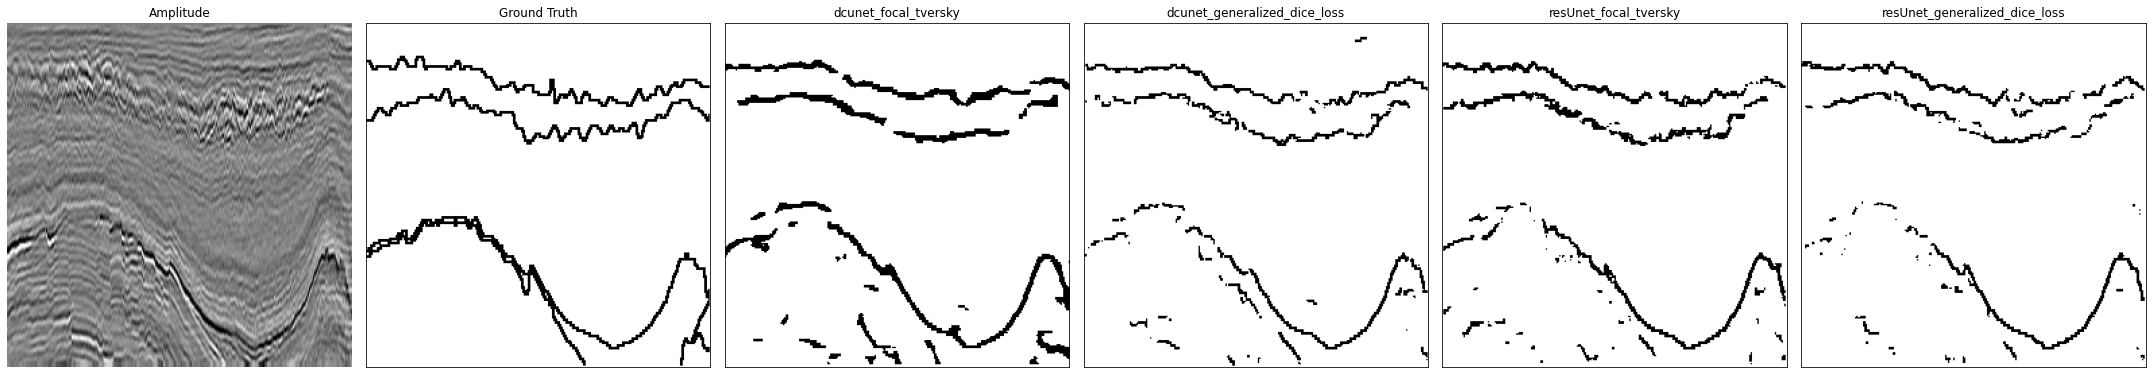

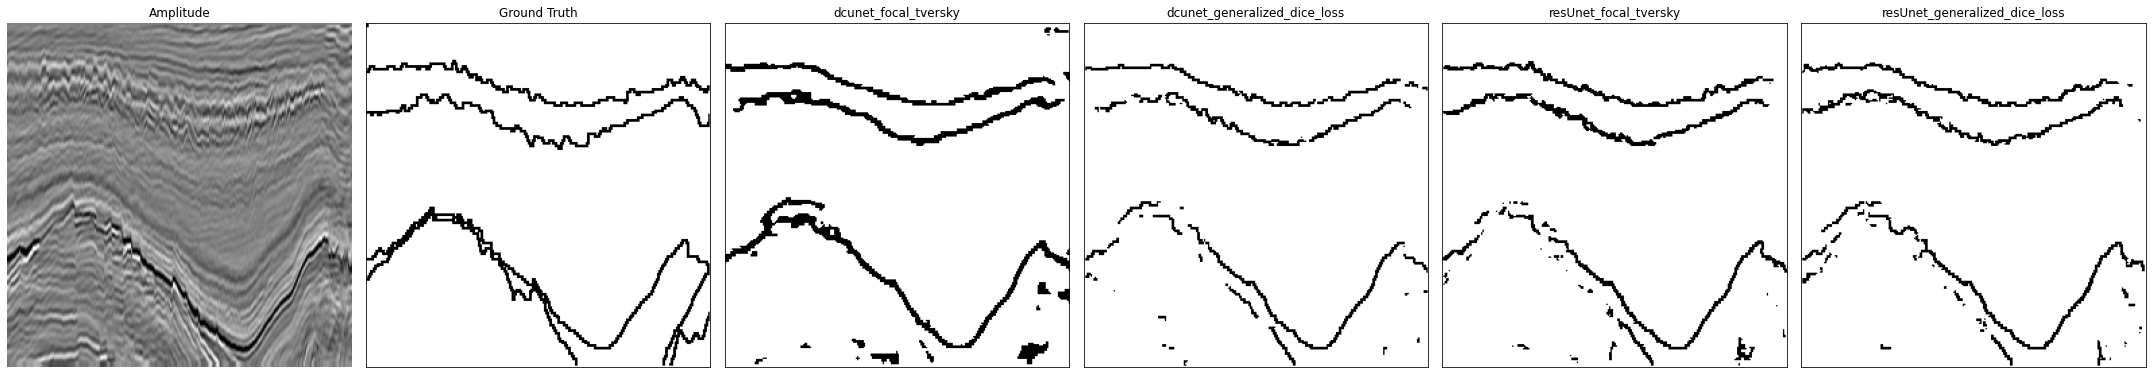

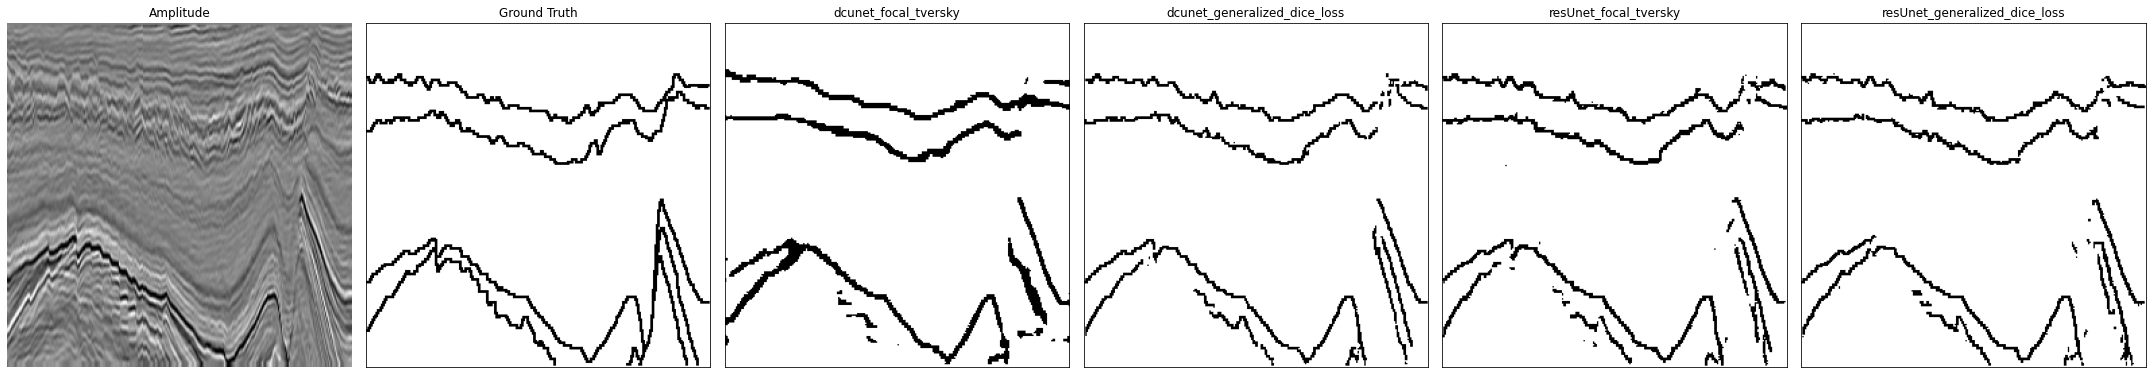

In [17]:
names = []

for cm in config_models:
       names.append(cm.name_model + '_' + cm.name_loss) 

for i in results_i_view:
        show_predicts1(config_models, i, names, amplitude=True, amplitude_gt=False, ground_truth=True)


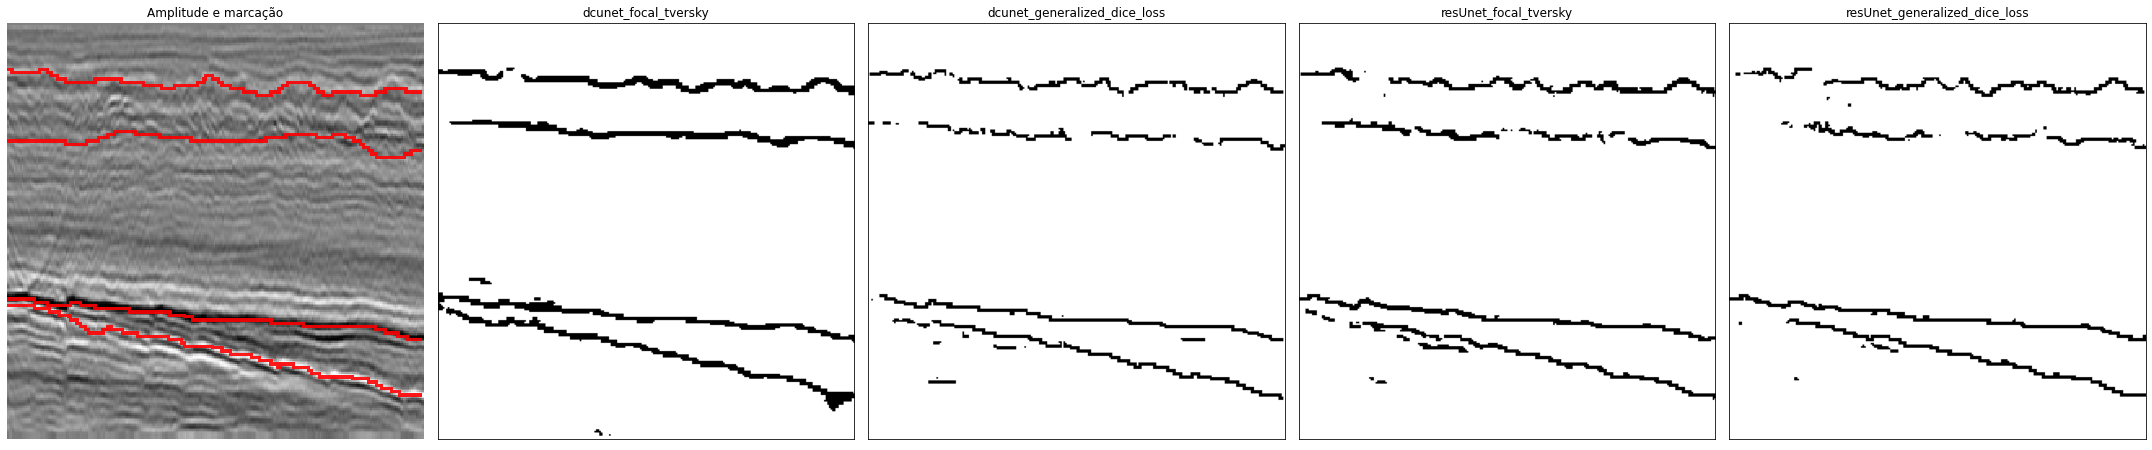

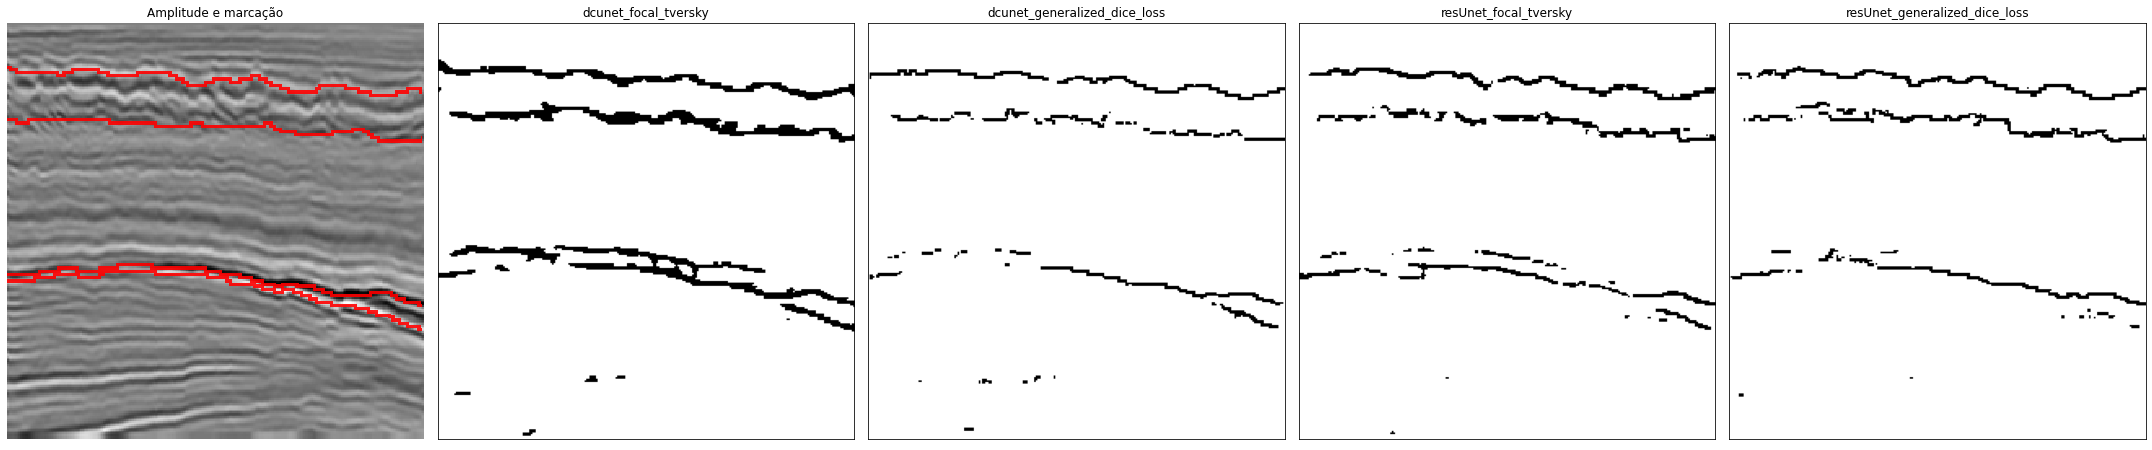

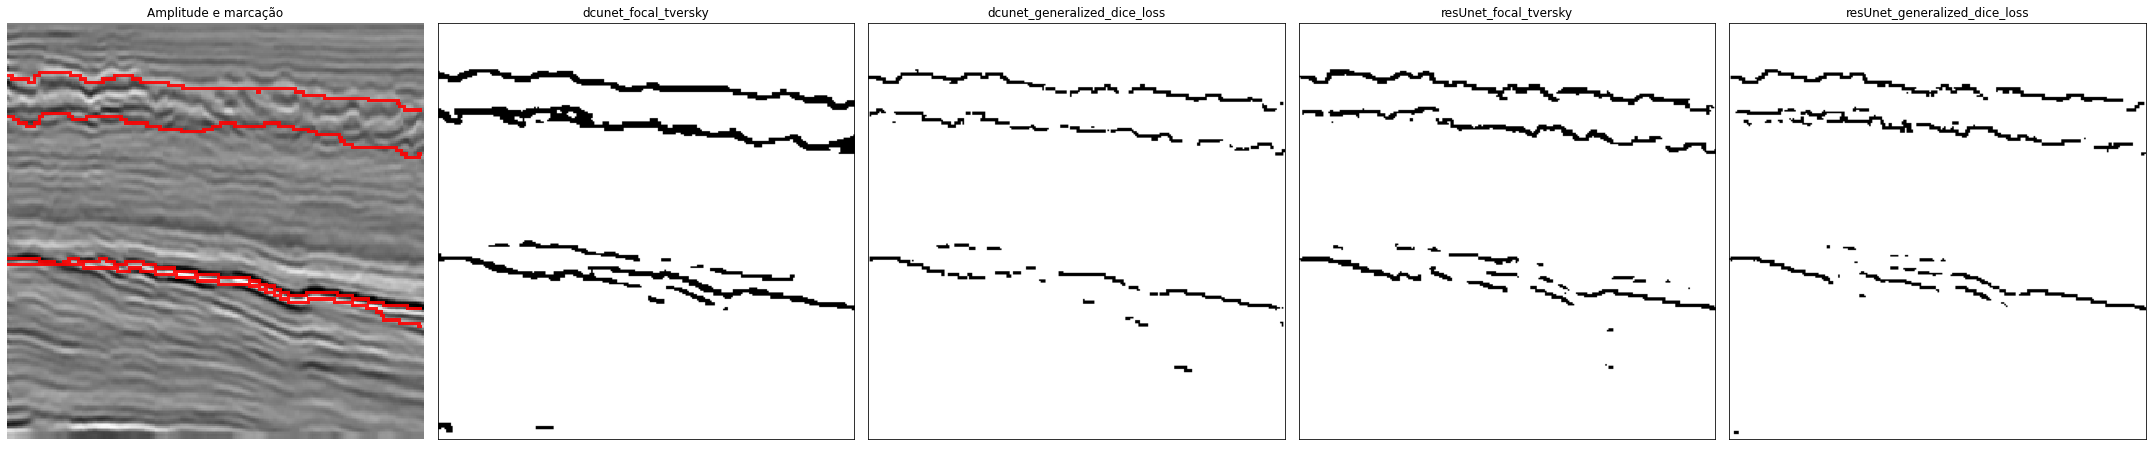

In [79]:
for x in results_x_view:
    show_predicts1(config_models, x, names, amplitude=False, amplitude_gt=True, ground_truth=False)

### Patches

In [91]:
# Carrega as configurações para cada modelo
logs_paths = ["resUnet/1_resUnet_focal_tversky_patche_256/"]

config_models_patches = []
for log_path in logs_paths:
    config_model = load_config(log_path)
    config_models_patches.append(config_model)
    

In [92]:
print(config_models[0].__dict__)

{'prefixo': '1_', 'image_width': 256, 'image_height': 256, 'input_size': (256, 256, 1), 'batch_size': 8, 'num_classes': 1, 'num_channels': 1, 'num_epochs': 300, 'resize': False, 'augmentation': True, 'neighborhood': 8, 'split': False, 'EarlyStopping': True, 'name_model': 'resUnet', 'dataset_path': '/data/mayaragomes/dissertacao/', 'folder_modeling_path': '/data/mayaragomes/dissertacao/proposta/segmentation/resUnet/1_resUnet_focal_tversky_patche_256', 'name_modelagem': '1_resUnet_focal_tversky_patche_256', 'name_loss': 'focal_tversky', 'inline': True, 'crossline': True, 'ksize': 256, 'strides': 256, 'padding': 'SAME', 'patche': True, 'baselist': None, 'warmup_epoch': 15, 'learning_rate': 0.001, 'learning_rate_callback': ''}


In [93]:
splits = ['test1', 'test2']
base_teste1_patches = load_dataset_test(config_models[0], splits[0])

In [94]:
print(splits[0], config_models[0].dataset_path, config_models[0].image_width)

test1 /data/mayaragomes/dissertacao/ 256


In [95]:
# Carrega os modelos
models_patches = []
for c in config_models_patches:
    m = load_model(c, 0)
    models_patches.append(m)

modelo ResUnet


In [99]:
cont = 0
results_x_view_patches = []
results_i_view_patches = []
num_direction_x_view_patches = ['1', '100', '199']
num_direction_i_view_patches = ['1', '155', '189']
print('Teste1: ', len(base_teste1))
for (images, masks, directions, numbers, indexs, shape) in base_teste1:
    
    #print(images[0].shape)
    # Salva as predições de crossline escolhidas
    if directions == 'x':
        if numbers in num_direction_x_view_patches:
            results_x = predictons_list(config_models_patches, models_patches, images, masks, shape)
            results_x_view_patches.append(results_x)

    # Salva as predições de inlines escolhidas
    elif directions == 'i':
        if numbers in num_direction_i_view_patches:
            results_i = predictons_list(config_models_patches, models_patches, images, masks, shape) 
            results_i_view_patches.append(results_i)

    cont += len(images)

Teste1:  901


TypeError: 'NoneType' object is not subscriptable